<a href="https://colab.research.google.com/github/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/05_AI_for_Bioacoustics/05_AI_for_Bioacoustics_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5: AI for Bioacoustics [Solutions]

In this week's practical we will explore computer audition applications in ecology, such as
automated animal detection and species classification from audio sensor data!

## Contents

1. [Introduction](#1-introduction)
2. [Setup](#2-setup)
3. [Detecting Animal Sounds](#3-detecting-animal-sounds)
4. [Identifying Sounds](#4-identifying-sounds)
5. [Conclusion](#5-conclusion)


## Notes

- If a line starts with the fountain pen symbol (🖌️), it asks you to implement a code part or
answer a question.
- Lines starting with the light bulb symbol (💡) provide important information or tips and tricks.

---

## 1. Introduction

### 1.1 Computer Audition

Computer audition is the field of research that deals with the automatic analysis of audio signals.
It intersects with many other fields, including machine learning, signal processing, and computer
vision.

**What does a computer hear**?

- Audio files are a sequence of numbers representing the amplitude of the sound
  wave at a given time.

- The number of samples per second is called the **sampling rate**.

<img alt="audio and sampling rate" width="600"
src="https://cdn.shopify.com/s/files/1/1169/2482/files/Sampling_Rate_Cover_image.jpg?v=1654170259"></img>

**What tasks can we do with computer audition?**

Computer audition is used in a wide range of applications, including:

- Speech recognition: Siri, Alexa, Google Assistant
- Music information retrieval: Spotify, Shazam
- Audio classification: What is sounding in this audio?
- Sound event detection: Transcription of audio into a sequence of events.

<img alt="Sound event detection" width="400"
src="http://d33wubrfki0l68.cloudfront.net/508a62f305652e6d9af853c65ab33ae9900ff38e/17a88/images/tasks/challenge2016/task3_overview.png"></img>

> Taken from the paper: Mesaros, A., Heittola, T., Diment, A., Elizalde, B., Shah, A., Vincent, E.,
> ... & Virtanen, T. (2017, November). DCASE 2017 challenge setup: Tasks, datasets and baseline
> system. In DCASE 2017-Workshop on Detection and Classification of Acoustic Scenes and Events.

Recently, deep learning has taken over the field of computer audition and is being used to solve
many of the above tasks.

### 1.2 Data Collection

**Acoustic sensors** can be used to collect field recordings of animal sounds.

Usually, these sensors are deployed statically in the field for a long periods of time and record
sounds continuously. This is called **passive acoustic monitoring**.

<img alt="passive acoustic monitoring" width="400"
src="https://wittmann-tours.de/wp-content/uploads/2018/06/AudioMoth.jpg"></img>

Alternatively, recordings are actively directed towards a specific animal species or sound events.

<img alt="active recording" width="400"
src="https://s3.amazonaws.com/cdn.freshdesk.com/data/helpdesk/attachments/production/48032687175/original/xjI7Dy3Q9kaCZinr5vf4ksNxQbjK13Yv3A.jpg?1584552543"></img>

> Taken from the Macaulay Library blog post: [Sound recording
> tips](https://support.ebird.org/en/support/solutions/articles/48001064298-sound-recording-tips).

### 1.3 Acoustics for Ecology

The sound at a site is a reflection of the species present in the area and other
environmental factors.

<img alt="composition of acoustic space" width="500"
src="https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs12304-017-9288-5/MediaObjects/12304_2017_9288_Fig1_HTML.gif?as=webp"></img>

> Taken from the paper: Mullet, T.C., Farina, A. & Gage, S.H. The Acoustic
> Habitat Hypothesis: An Ecoacoustics Perspective on Species Habitat Selection.
> Biosemiotics 10, 319–336 (2017). https://doi.org/10.1007/s12304-017-9288-5

If we could link the sounds to the species, we could use this information to
study and monitor the biodiversity of an area.

Acoustic sensors produce a lot of data, and it is not always easy to analyse.
Can we use computer audition to help us?

In this practical, we will explore the task of **animal sound detection** and **species
classification**, using both manual and automated methods.


---

## 2. Setup

### 2.1 Enable GPU Runtime

Go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

### 2.2 Mount Google Drive

In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Add a shortcut in you drive to this [shared folder](https://drive.google.com/drive/folders/1hbbbsILNBsQghktuj0z_Jq_3iEZQCCbj?usp=share_link).

This will allow you to access the data we will use in this practical.

In [5]:
%%capture
# Extract data into machine
!unzip /content/drive/MyDrive/week4_data.zip -d /content/week4_data

In [6]:
DATA_DIR = "/content/week4_data/data"

### 2.3 Install and Import Dependencies

Run the following cell to install the required dependencies. This will take a few minutes.

In [1]:
%%capture
%pip install --no-dependencies git+https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment.git batdetect2
%pip install umap-learn wavio

In [ ]:
import glob
import os
from time import perf_counter

import ipywidgets
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_hub as hub
from IPython.display import Audio
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from umap import UMAP

from bios0032utils.bioacoustics import evaluate_detection, plotting
from bios0032utils.bioacoustics.classification import (
    load_bat_call_audio_data
)

---

## 3: Detecting Animal Sounds

- Most of the time, we are not interested in all the sounds in a recording, but only in the sounds
  of a specific animal species.

- Acoustic sensors will indiscriminately record all sounds in the environment, including those of
  animals, wind, rain, _etc._ Although some recorders can be triggered by a specific sound, this is
  not always the case.

- Passive acoustic monitoring produces many hours of recordings, and it's hard to identify and
  explore the sounds of interest.

These are similar problems to the ones we have seen in the previous practicals for camera trap
images.

While not as developed as in **computer vision**, there are some tools for automatically **detecting
animal sounds** in recordings. Here we will explore a few of them.

But first we need to understand how to visualise and annotate sounds.

### 3.1 Animal Sounds Visualisation

- While we can listen to the sounds in a recording, it is often easier to visualise them.

- This is especially true when we want to compare sounds from different recordings or navigate
quickly without the need to listen.

- We can use waveplots and spectrograms to visualise the sounds in a recording.

Now we will load a dataset of animal recordings provided by
[Avisoft](https://www.avisoft.com/animal-sounds/) and visualise them.

In [7]:
AVISOFT_AUDIO_DIR = os.path.join(DATA_DIR, "avisoft", "audio")
AVISOFT_METADATA_FILE = os.path.join(DATA_DIR, "avisoft", "avisoft_metadata.csv")

In [8]:
# Load the metadata dataframe
avisoft = pd.read_csv(AVISOFT_METADATA_FILE)

In [9]:
# Print first few rows
avisoft.head()

english_name         scientific_name  \
0  Little Grebe  Tachybaptus ruficollis   
1  Little Grebe  Tachybaptus ruficollis   
2       Bittern      Botaurus stellaris   
3     Corncrake               Crex crex   
4     Corncrake               Crex crex   

                                           href      key   kingdom    phylum  \
0    https://www.avisoft.com/sounds/zwergta.wav  2482048  Animalia  Chordata   
1   https://www.avisoft.com/sounds/zwergta2.wav  2482048  Animalia  Chordata   
2   https://www.avisoft.com/sounds/rohrdomm.wav  2480910  Animalia  Chordata   
3   https://www.avisoft.com/sounds/corncrak.wav  4408498  Animalia  Chordata   
4  https://www.avisoft.com/sounds/corncrak2.wav  4408498  Animalia  Chordata   

              order         family        genus                 species class  \
0  Podicipediformes  Podicipedidae  Tachybaptus  Tachybaptus ruficollis  Aves   
1  Podicipediformes  Podicipedidae  Tachybaptus  Tachybaptus ruficollis  Aves   
2    Pelecaniformes       Ardeidae     Botaurus      Botaurus stellaris  Aves   
3        Gruiformes       Rallidae         Crex               Crex crex  Aves   
4        Gruiformes       Rallidae         Crex               Crex crex  Aves   

                            wav  
0    tachybaptus_ruficollis.wav  
1  tachybaptus_ruficollis_1.wav  
2        botaurus_stellaris.wav  
3                 crex_crex.wav  
4               crex_crex_1.wav

In [10]:
# select a random file from the dataset
random_recording = avisoft.sample(n=1).iloc[0]

# read the audio file and import it as a numpy array
wav, samplerate = librosa.load(
    os.path.join(AVISOFT_AUDIO_DIR, random_recording.wav),
    sr=None
)

# Compute the duration of audio
num_samples = len(wav)  # Number of samples taken by the recorder
duration = num_samples / samplerate

# Get name of animal
animal_name = random_recording.english_name

print(f"File selected = {random_recording.wav}")
print(f"Samplerate = {samplerate} Hz")
print(f"Duration = {duration:.2f} s")
print(f"Species = {animal_name}")

File selected = parus_montanus_1.wav
Samplerate = 22050 Hz
Duration = 1.96 s
Species = Willow Tit


Let us first listen to the audio:

In [11]:
Audio(data=wav, rate=samplerate)

Text(0.5, 1.0, 'Waveform of Willow Tit sound')

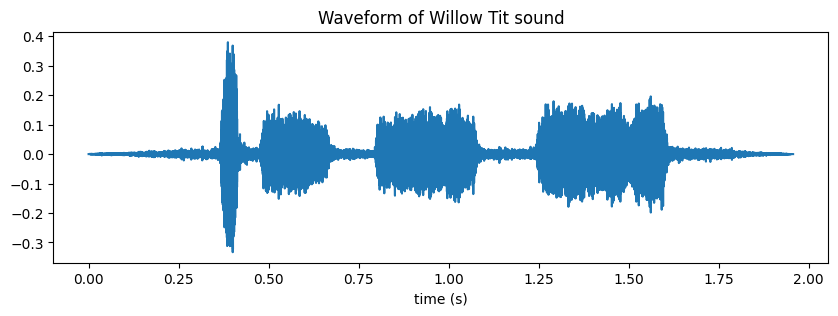

In [12]:
# Create plot of the waveform
times = np.linspace(0, duration, num_samples)
plt.figure(figsize=(10, 3))
plt.plot(times, wav)
plt.xlabel("time (s)")
plt.title(f"Waveform of {animal_name} sound")

The **waveform** gives us a visual representation of the sound amplitude over time.

However, if there are multiple simultaneous sounds in the recording, it can be hard to see each
individual sound.

We can use a **spectrogram** to decompose the sound into **frequencies** and visualise them as a 2D
image.

In [13]:
# Compute the spectrogram with the short time fourier transform (STFT)
spectrogram = np.abs(librosa.stft(wav))

# Amplitude is best represented in logarithmic scale (decibels)
db_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

Text(0, 0.5, 'freq (Hz)')

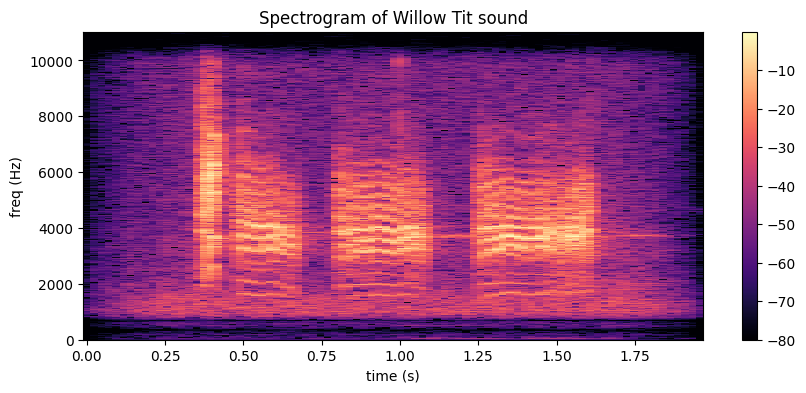

In [14]:
# Create plot of spectrogram
num_freq_bins, num_time_bins = db_spectrogram.shape
times = np.linspace(0, duration, num_time_bins)
freqs = np.linspace(0, samplerate / 2, num_freq_bins)

plt.figure(figsize=(10, 4))
plt.pcolormesh(times, freqs, db_spectrogram, cmap="magma")
plt.colorbar()
plt.title(f"Spectrogram of {random_recording.english_name} sound")
plt.xlabel("time (s)")
plt.ylabel("freq (Hz)")

### 3.2 Exercise 🐘

The sounds produced by animals can be very different from each other. The transformation used to
create the spectrogram, called the **short-time Fourier transform** (STFT), will highlight different
features of the sound depending on the parameters used.

🖌️ Research what the STFT is and how its parameters affect the spectrogram. In particular, try to
  understand the effect of the **window size** and the **hop size** or **overlap**.

_Solution:_

The **Fourier transform** is a method for breaking a time series into its continuent frequencies.
[Click here](https://www.youtube.com/watch?v=spUNpyF58BY) if you are interested in an intuitive and
visual explanation of the Fourier transform.

For the **short-time Fourier transform** the audio is broken up into  **windows** (or **chunks** or
**frames**), which usually overlap each other. Each **window** is Fourier transformed, and the
result is added to a matrix, which records magnitude for each point in time and frequency.

![short time fourier
transform](https://www.mdpi.com/applsci/applsci-10-07208/article_deploy/html/images/applsci-10-07208-g001-550.jpg)

In order to compute a **STFT** of a signal you must select a `window_length` (or `n_fft`) and a
`hop_length` (or `overlap`) to determine how to break up the signal into **windows**.

* The `hop_size` controls the temporal resolution, or the minimum interval at which you can detect
  changes in sound. If `hop_length = 128` then any transient sounds of length less than 128 samples
  will be hard to detect.

* The `window_length` controls the frequecy resolution. With larger `window_length` it is possible
  to distinguish between closer frequencies.

* Selecting a high/low value for `window_length` will produce spectrograms with many/few frequency
  bins.

* Similarly, a high/low value for `hop_length` will produce spectrograms with many/freq time bins.

Here you can visualise sounds from different species and see how the STFT parameters affect the
spectrogram.

In [15]:
# @title Interactive spectrogram of animal sounds

# @markdown Select the file you wish to visualize. Modify the spectrogram parameters to see its effect on the spectrogram. Change the reproduction speed for interesting effects!

# Select some varied sounds from avisoft dataset
examples = [
    (row.english_name, os.path.join(AVISOFT_AUDIO_DIR, row.wav))
    # select one random recording per taxonomic group
    for row in avisoft.groupby("order").sample(n=1).itertuples()
]

# Create interactive plot
ipywidgets.interact(
    plotting.plot_waveform_with_spectrogram,
    hop_length=(32, 1024, 32),
    n_fft=(32, 2048, 32),
    window=plotting.WINDOW_OPTIONS,
    file=examples,
    cmap=plotting.COLORMAPS,
    speed=[
        ("x1", 1),
        ("x1.5", 1.5),
        ("x2", 2),
        ("x0.5", 0.5),
        ("x0.2", 0.2),
        ("x0.1", 0.1)
    ]
)

interactive(children=(Dropdown(description='file', options=(('Marsh Harrier', '/content/week4_data/data/avisof…

<function bios0032utils.bioacoustics.plotting.plot_waveform_with_spectrogram(file: str, hop_length: int = 128, n_fft: int = 256, window: str = 'hann', cmap: str = 'plasma', speed: int = 1)>

Try changing the parameters and see how they affect sounds from different species.

🖌️ Can you see that some choice of parameters are good for some species but not for others?

_Solution:_

Some species have slowly changing frequency, like a Sheep, hence selecting a high `hop_length` would
be able to capture its vocalization accurately without few temporal samples.

Other species, such as the Little Grebe, have quickly varying frequencies, and a high `hop_length`
would blur the intricacies of its song.

A small `window_length` can be chosen in case identification does not rely on accurate frequency
information. For example the Hoopoe call consists of a burst of three rapid pulses at low
frequencies. This pattern can be cleary distinguished even with low frequency resolution.

Ofter species will call at similar frequency bands. In such case it's best to select a
`window_length` that will produce enough frequency resolution to distinguish between similar calls.

🖌️ How do the parameters affect the computation time and resulting image size?

_Solution:_

* Larger `window_length` will produce taller spectrograms and slow down computation time.
* Smaller `hop_length` will produce lengthier spectrograms and slow down computation time.

In [16]:
# take a single file
species, filepath = examples[0]

print(f"Will generate multiple spectrograms of {species} sounds. Using the file: {filepath}")

# load the audio
wav, sr = librosa.load(filepath, sr=None)

# select multiple choices of window_length and hop_length
window_lengths = np.arange(64, 2048, 64)
hop_lengths = np.arange(32, 1024, 32)

# create list in which to store the resulting computation times
computation_times = []

# iterate over all window_length and hop_length options
for window_length in window_lengths:
    for hop_length in hop_lengths:
        # start counter
        computation_time = perf_counter()

        # compute spectrogram
        spectrogram = librosa.amplitude_to_db(
            np.abs(
                librosa.stft(
                    wav,
                    hop_length=hop_length,
                    n_fft=window_length,
                    window="hann"
                )
            ),
            ref=np.max
        )

        # end counter
        computation_time = perf_counter() - computation_time

        # store result in computation_times list
        computation_times.append(
            {
                "window_length": window_length,
                "hop_length": hop_length,
                "computation_time": computation_time,
                "spectrogram_size": spectrogram.size
            }
        )

# convert computation_times list into a pandas dataframe
computation_times = pd.DataFrame(computation_times)

Will generate multiple spectrograms of Marsh Harrier sounds. Using the file: /content/week4_data/data/avisoft/audio/circus_aeruginosus_1.wav


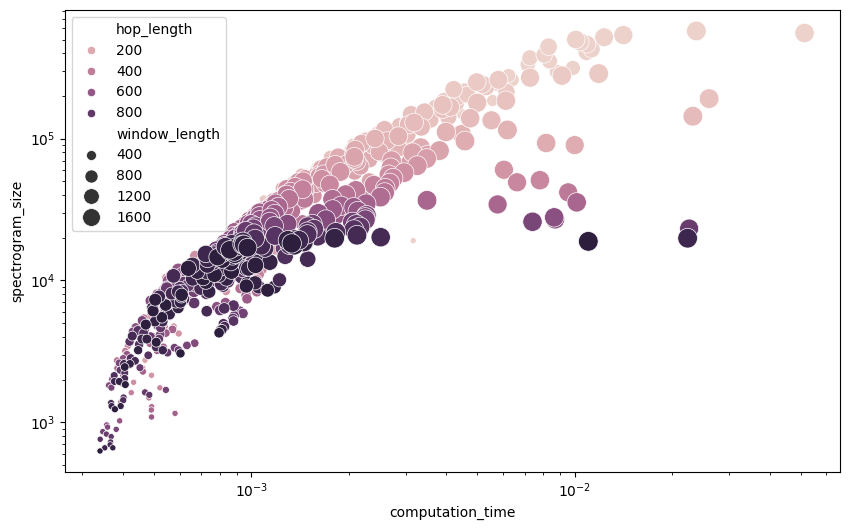

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=computation_times,
    x="computation_time",
    y="spectrogram_size",
    size="window_length",
    hue="hop_length",
    sizes=(20, 200)
)
ax.set_xscale("log")
ax.set_yscale("log")

### 3.3 Detecting Sounds

As you can imagine, it is not easy to manually annotate all relevant sounds in a recording.

Take a look at this recording:

In [18]:
YUCATAN_METADATA = os.path.join(DATA_DIR, "yucatan", "yucatan_metadata.csv")

YUCATAN_AUDIO_DIR = os.path.join(DATA_DIR, "yucatan", "audio")

# Load metadata of dataset of bat recordings from the Yucatan peninsula
yucatan = pd.read_csv(YUCATAN_METADATA)

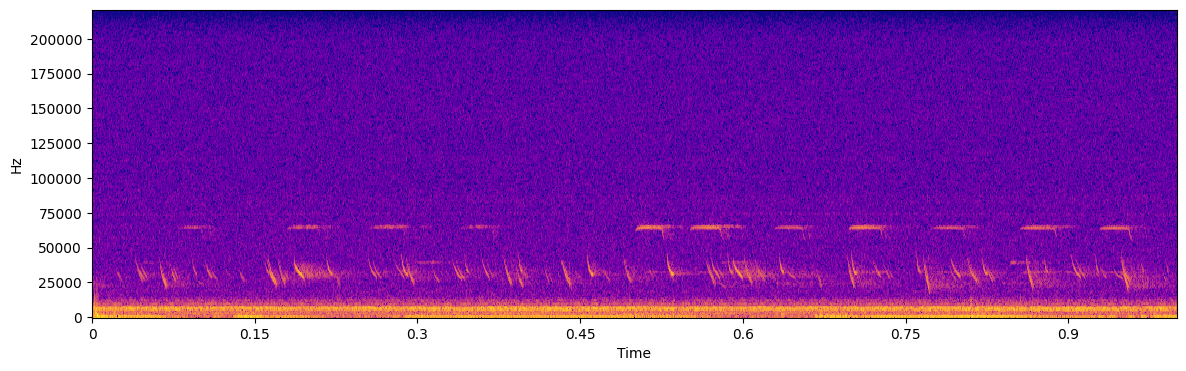

In [19]:
crowded_recording = os.path.join(YUCATAN_AUDIO_DIR, yucatan.id[1017])

plotting.plot_spectrogram(
    crowded_recording,
    hop_length=128,
    n_fft=512,
    figsize=(14, 4)
)

There are many bat calls in this recording, and it would be very time-consuming to annotate them
all.

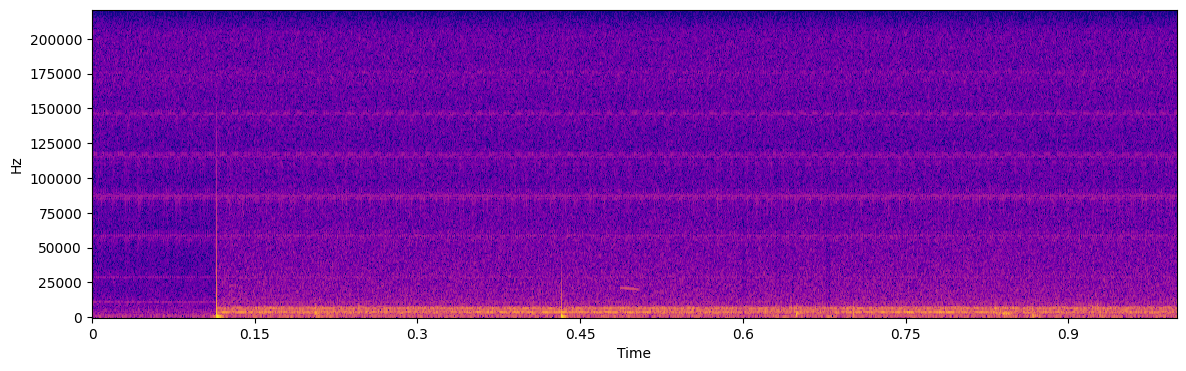

In [20]:
empty_recording = os.path.join(YUCATAN_AUDIO_DIR, yucatan.id[205])
plotting.plot_spectrogram(
    empty_recording,
    hop_length=128,
    n_fft=512,
    figsize=(14, 4)
)

This other recording has a single bat pulse. You still need to review it thoroughly to make sure
there are no other sounds of interest.

### 3.4 BatDetect2

Similar to **MegaDetector** for camera traps, there are some tools that automatically detect animal
sounds in recordings.

Various models have been developed and trained for different taxon groups. The following are very
popular examples, all using deep learning:

#### Birds

**BirdNET:** A convolutional neural network from Cornell University for classifying over 5,000 bird
calls in audio recordings.
> Kahl, S., Wood, C.M., Eibl, M. and Klinck, H., 2021. BirdNET: A deep learning solution for avian
> diversity monitoring. Ecological Informatics, 61, p.101236.
> [https://www.sciencedirect.com/science/article/pii/S1574954121000273](https://www.sciencedirect.com/science/article/pii/S1574954121000273)

[GitHub](https://github.com/kahst/BirdNET-Analyzer)

**Perch:** Similar idea; model trained on over 10,000 species.
[GitHub](https://github.com/google-research/perch)


#### Bats

**BatDetect2:** A framework in PyTorch for simultaneous detection and classification of UK bats.
> Aodha, O.M., Martínez Balvanera, S., Damstra, E., Cooke, M., Eichinski, P., Browning, E.,
> Barataud, M., Boughey, K., Coles, R., Giacomini, G. and Swiney G, M.C.M., 2022. Towards a general
> approach for bat echolocation detection and classification. bioRxiv, pp.2022-12.
> [https://www.biorxiv.org/content/10.1101/2022.12.14.520490v1.abstract](https://www.biorxiv.org/content/10.1101/2022.12.14.520490v1.abstract)

[GitHub](https://github.com/macaodha/batdetect2)


Below, we will use BatDetect2 on our data. Although the model was trained on UK bat calls, we can
still test its detection performance on the dataset of bats from the Yucatán peninsula.

💡 Make sure to use a GPU runtime for this. Even so, completion may take a while as we have quite a
number of audio recordings to analyse.

In [21]:
%%bash
batdetect2 detect /content/week4_data/data/yucatan/audio /content/week4_data/data/yucatan/predictions 0.3


BatDetect2 - Detection and Classification
    Assumes audio files are mono, not stereo.
    Spaces in the input paths will throw an error. Wrap in quotes.
    Input files should be short in duration e.g. < 30 seconds.

Loading model: /usr/local/lib/python3.11/dist-packages/batdetect2/models/Net2DFast_UK_same.pth.tar

Input directory: /content/week4_data/data/yucatan/audio
Number of audio files: 1395

Saving results to: /content/week4_data/data/yucatan/predictions

Processing Configuration:
Time Expansion Factor: 1
Detection Threshold: 0.3

0 /content/week4_data/data/yucatan/audio/dry_stateresa_1_110305_19200_20200.wav
2 call(s) detected above the threshold.
species name                  probablity present
Nyctalus leisleri             0.449
Nyctalus noctula              0.386
Eptesicus serotinus           0.155

1 /content/week4_data/data/yucatan/audio/rain_stamaria_1_260903_24580_25580.wav
7 call(s) detected above the threshold.
species name                  probablity present
Pipist

💡 BatDetect2 internally computes spectrograms to detect and classify bat calls, just like we
manually did above ([source
code](https://github.com/macaodha/batdetect2/blob/2100a3e483116037c57698c72bbe506c604ebd0b/batdetect2/train/audio_dataloader.py#L521)).

**BatDetect2** can predict multiple bounding boxes for each recording. Each bounding box has a
**score**, a predicted species and a confidence score for the species.

Here, we will throw out the predicted species and confidence score, and only use the bounding box
score. The **score** is the probability that the bounding box contains a bat call.

In [22]:
# Get all prediction files made by BatDetect2 (CSV format)
files = glob.glob(os.path.join(DATA_DIR, "yucatan", "predictions", "*.csv"))

# Read each prediction file
batdetect2_predictions = []
for path in files:
    df = pd.read_csv(path).drop(columns=["id", "class", "class_prob"])
    df["recording_id"] = os.path.basename(path)[:-4]
    batdetect2_predictions.append(df)

# And concatenate them into a single dataframe
batdetect2_predictions = pd.concat(batdetect2_predictions)

# show the first few rows of predictions made by BatDetect2
batdetect2_predictions.head()

det_prob  start_time  end_time  high_freq  low_freq  \
0     0.787      0.0085    0.0249      26389     22031   
1     0.601      0.0595    0.0645      30960     13437   
2     0.400      0.3745    0.3794      33182     21171   
3     0.375      0.4105    0.4151      32738     19453   
4     0.560      0.4915    0.5040      21989     15156   

                             recording_id  
0  rain_tortugas_1_160803_36680_37680.wav  
1  rain_tortugas_1_160803_36680_37680.wav  
2  rain_tortugas_1_160803_36680_37680.wav  
3  rain_tortugas_1_160803_36680_37680.wav  
4  rain_tortugas_1_160803_36680_37680.wav

Are these good predictions? To find out, we need to compare them to ground truth.

Let us load some previously made ground truth annotations first.

In [23]:
# Load the annotations file
yucatan_annotations = pd.read_csv(os.path.join(DATA_DIR, "yucatan", "yucatan_annotations.csv"))

# show the first few rows
yucatan_annotations.head()

recording_id  end_time  start_time      low_freq  \
0  dry_azul_1_140305_54686_55686.wav  0.581549    0.573141  37467.773438   
1  dry_azul_1_140305_54686_55686.wav  0.995651    0.986776  24978.515625   
2  dry_azul_1_140305_54686_55686.wav  0.930721    0.922780  41774.414063   
3  dry_azul_1_140305_54686_55686.wav  0.849209    0.837764  36606.445313   
4  dry_azul_1_140305_54686_55686.wav  0.576410    0.566134  41343.750000   

      high_freq         event                 class  
0  43066.406250  Echolocation  Pteropteryx macrotis  
1  28854.492188  Echolocation                   Bat  
2  45219.726563  Echolocation  Pteropteryx macrotis  
3  43066.406250  Echolocation  Pteropteryx macrotis  
4  45219.726563  Echolocation  Pteropteryx macrotis

Now, we can compare the detections with the ground truth. We can use the Intersection-over-Union
(IoU) to measure the overlap between the detections and the ground truth.

<img alt="intersection over union"
src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png"
width="400"></img>

Intuitively, the relationship between overlap (intersection) and union tells us how geometrically
similar two bounding boxes are. An IoU of 1 means that both boxes are congruent (perfectly
overlapping), for IoU 0 the two boxes don't even touch each other.

We usually cannot expect a machine learning model to always produce perfectly identical bounding
boxes as provided in the ground truth. Hence, we need to set a minimum IoU value for which
we count a prediction as "correct". We will use such an _IoU threshold_ of 0.5 below.

In [24]:
# Select the predictions and annotations from the crowded recording
file_detections = batdetect2_predictions[
    batdetect2_predictions.recording_id == os.path.basename(crowded_recording)
]
file_annotations = yucatan_annotations[
    yucatan_annotations.recording_id == os.path.basename(crowded_recording)
]

# Match the bounding boxes by computing the IoU. Discard all matches with IoU less than 0.5
pred_boxes = evaluate_detection.bboxes_from_annotations(file_detections)
true_boxes = evaluate_detection.bboxes_from_annotations(file_annotations)
matches = evaluate_detection.match_bboxes(true_boxes, pred_boxes, iou_threshold=0.5)

We can now distinguish three different cases (remember lecture from Session 2):
* **True Positives (TP)**: _detections_ with IoU >= threshold
* **False Positives (FP)**: _detections_ with IoU < threshold
* **False Negatives (FN)**: _annotations_ with no matching detection

In [25]:
# total number of annotated sound events
positives = len(file_annotations)

num_predictions = len(file_detections)

# number of matched prediction boxes
true_positives = len(matches)

# number of predicted boxes that were not matched
false_positives = num_predictions - len(matches)

# number of annotated sound events that were not matched
false_negatives = positives - len(matches)

With this information, we can compute the precision and recall of the detections:
$$
\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}
$$

In [26]:
# Percentage of predictions that are correct
precision = true_positives / num_predictions

# Percentage of sound events that were detected
recall = true_positives / positives

print(f"BatDetect2 precision={precision:.1%} recall={recall:.1%} on file {crowded_recording}")

BatDetect2 precision=53.3% recall=35.3% on file /content/week4_data/data/yucatan/audio/rain_tortugas_2_160803_38645_39645.wav


Now, we can visualise predictions and ground truth annotations in the spectrograms together:

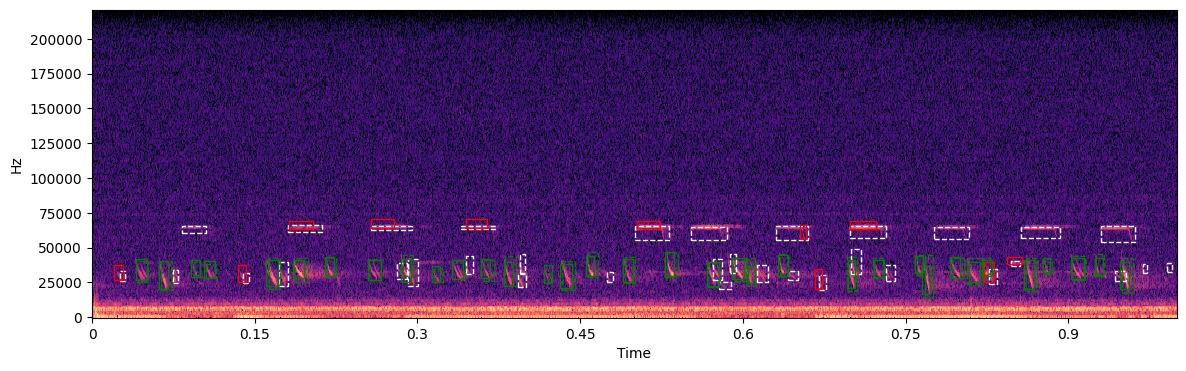

<Axes: xlabel='Time', ylabel='Hz'>

In [27]:
score_threshold = 0.3

plotting.plot_spectrogram_with_predictions_and_annotations(
    crowded_recording,
    batdetect2_predictions[batdetect2_predictions.det_prob > score_threshold],
    yucatan_annotations,
    iou_threshold=0.3
)

In the two visualisations above, bounding boxes are drawn in different styles:
- red = spurious predicted sound event (false positive)
- green = correct prediction (true positive)
- white = missed sound event (false negative)

Besides an IoU threshold, you will notice that we also need to set a _confidence threshold_, because
as explained above, BatDetect2 gives us probabilities (softmax-activated output logits; _cf._
Session 3).

We have set this rather arbitrarily to 0.3 above. You can imagine what happens if we increase or
decrease this threshold. Watch what happens for different files when you adjust IoU and confidence
thresholds in the widget below.

In [28]:
# @title Batdetect2 predictions

# @markdown Select a file and an IoU threshold.

example_files = [
    os.path.join(YUCATAN_AUDIO_DIR, row["id"])
    for _, row in yucatan.sample(n=20).iterrows()
]


@ipywidgets.interact(
    path=example_files,
    iou_threshold=(0, 1, 0.1),
    score_threshold=(0, 1, 0.1),
)
def plot_batdetect2_results_file_results(
    path=crowded_recording,
    iou_threshold=0.5,
    score_threshold=0.3,
):
    confident_detections = batdetect2_predictions[
        batdetect2_predictions.det_prob > score_threshold
    ]

    precision, recall = evaluate_detection.compute_file_precision_recall(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
    )

    print(
        f"Batdetect2 precision={precision:.1%} recall={recall:.1%} on file {crowded_recording}"
    )

    plotting.plot_spectrogram_with_predictions_and_annotations(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
        linewidth=2,
    )

interactive(children=(Dropdown(description='path', options=('/content/week4_data/data/yucatan/audio/rain_azul_…

### 3.6 Exercise 🐋

🖌️ With the code blocks above as help, implement the calculation of the following properties below:

* The mean precision and recall across all files.
* The percentage of files where all bat calls were missed.

In [29]:
precisions, recalls = [], []        # lists of per-file precision and recall scores
files_missed = 0                    # counter for number of files where all calls were missed


for recording_id in batdetect2_predictions.recording_id.unique():
    file_detections = batdetect2_predictions[
        batdetect2_predictions.recording_id == recording_id
    ]
    file_annotations = yucatan_annotations[
        yucatan_annotations.recording_id == recording_id
    ]

    # Match the bounding boxes by computing the IoU. Discard all matches with IoU less than 0.5
    pred_boxes = evaluate_detection.bboxes_from_annotations(file_detections)
    true_boxes = evaluate_detection.bboxes_from_annotations(file_annotations)
    matches = evaluate_detection.match_bboxes(true_boxes, pred_boxes, iou_threshold=0.5)

    # total number of annotated sound events
    positives = len(file_annotations)

    num_predictions = len(file_detections)

    # number of matched prediction boxes
    true_positives = len(matches)

    # number of predicted boxes that were not matched
    false_positives = num_predictions - len(matches)

    # number of annotated sound events that were not matched
    false_negatives = positives - len(matches)

    # Percentage of predictions that are correct
    if num_predictions == 0:
        precision = 0
    else:
        precision = true_positives / num_predictions

    # Percentage of sound events that were detected
    if positives == 0:
        recall = 0
    else:
        recall = true_positives / positives

    precisions.append(precision)
    recalls.append(recall)

    # increment counter if all bat calls were missed
    if true_positives == 0 and positives > 0:
        files_missed += 1

print(f"Mean precision = {np.mean(precisions):.2%}, Mean recall = {np.mean(recalls):.2%}.")
print(f"Percent of files where all bat calls were missed = {files_missed/len(precisions):.2%}.")

Mean precision = 24.84%, Mean recall = 25.92%.
Percent of files where all bat calls were missed = 19.93%.


🖌️ Run the full evaluation again but change the `iou_threshold` parameter. What do you observe?

_Solution:_

* Increasing the **IoU threshold** makes it harder to find matches (`true_positives`). Recall will
  necessarily be lowered, as less bat calls can be detected. Precision will also be lowered as less
  detections can be correct.

* Conversely, a lower **IoU threshold** increases the number of matches (`true_positives`), making
  both recall and precision greater.

* Selecting an **IoU threshold** is not about optimizing performance, but about choosing a matching
  criterion. Having a low **IoU** threshold might increase the recall and precision but incurr a
  cost in precision of the bounding box of each detection.

We can visualise BatDetect2's predictions versus ground truth labels for a selection of audio files
below.

In [30]:
# @title Batdetect2 predictions

# @markdown Select a file and an IoU threshold.

example_files = [
    os.path.join(YUCATAN_AUDIO_DIR, row["id"])
    for _, row in yucatan.sample(n=20).iterrows()
]


@ipywidgets.interact(
    path=example_files,
    iou_threshold=(0, 1, 0.1),
    score_threshold=(0, 1, 0.1),
)
def plot_batdetect2_results_file_results(
    path=crowded_recording,
    iou_threshold=0.5,
    score_threshold=0.3,
):
    confident_detections = batdetect2_predictions[
        batdetect2_predictions.det_prob > score_threshold
    ]

    precision, recall = evaluate_detection.compute_file_precision_recall(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
    )

    print(
        f"Batdetect2 precision={precision:.1%} recall={recall:.1%} on file {crowded_recording}"
    )

    plotting.plot_spectrogram_with_predictions_and_annotations(
        path,
        confident_detections,
        yucatan_annotations,
        iou_threshold=iou_threshold,
        linewidth=2
    )

interactive(children=(Dropdown(description='path', options=('/content/week4_data/data/yucatan/audio/dry_stater…

---

## 4. Identifying Sounds

In the previous section, we saw how to detect sounds in a recording. But we still need to identify
the species that produced the sound.

Generally, classification is more challenging than detection, as the sounds produced by different
species can be very similar (**interspecific overlap**). Also, a single species can have flexible
vocalisations, think humans or mimic birds such as starling (**intraspecific variation**).

Bioacoustic data presents similar challenges to the camera trap datasets as recordings can be:
* **Ocluded** (Simultaneous sounds)
* **Appear in varying ambient conditions** (rain/wind/thunder)
* **Partial** (Only captured half the sound)
* **Noisy** (Saturation and faulty sensor)
* **Quiet or very loud** (depending on animal size, distance, environment)

For the rest of this notebook we will focus on **10** bat species present in the Yucatán dataset.

In [31]:
SPECIES = [
    "Mormoops megalophylla",
    "Myotis keaysi",
    "Saccopteryx bilineata",
    "Pteronotus davyi",
    "Pteronotus parnellii",
    "Lasiurus ega",
    "Pteropteryx macrotis",
    "Eumops underwoodi",
    "Rhogeessa aeneus",
    "Eptesicus furinalis"
]

In [32]:
classification_df = yucatan_annotations[yucatan_annotations["class"].isin(SPECIES)]

### 4.1 Bat Call Features

Previous research on bat call identification was based on hand-crafted features of the bat calls.
Measuring call features used to be a manual process.

<img src="https://www.elekon.ch/batexplorer2/doc/_images/CallParams.png" alt="call parameters" width="400"/>

> Image taken from the [BatExplorer 2.1 user guide](https://www.elekon.ch/batexplorer2/doc/batcall_params.html).

**Peak frequency [kHz]:**

>    The frequency at which the call is loudest (peak in the spectrum display), aka frequency of maximum energy (FME) or main frequency.
>    Most important parameter for bat classification because it can easily be measured and is often typical for a certain species or group of species.
>    The standard deviation of the peak frequency allows the detection of alternating calling species.
    
**Max frequency [kHz]**

>    The maximum frequency of the call. Often this is equal to the start frequency, for Rhinolophidae typically equal to the peak frequency.
    
**Min frequency [kHz]**

>    The minimum frequency of the call. Often this is equal to the end frequency, for hockey stick calls (e.g. Pipistrelle) it might be lower than the end frequency.
    
**BW Peak2Min [kHz]**

>    Bandwidth Peak2Min = Peak frequency - Min frequency
>    Often used to distinguish Myotis and Pipistrelle calls, Myotis mostly have higher bandwidth.
    
**Call length [ms]**

>    Time period of call start to call end in ms. Can be measured most accurately in the oscillogram (wave rise to wave drop).
>    Search calls from European bats are usually between one and up to approximately 30 ms (horseshoe bats up to 80 ms).
    
**Call distance [ms]**

>    Time period between two consecutive calls in ms. Can be measured most accurately in the oscillogram (wave rise call A to wave rise call B).
>    Often this parameter is not very significant since most bat species have irregular rhythms. But it can be an indicator for behavior.
>    Search calls from European bats usually have distances of about 30 to 300 ms, sometimes even longer.


### 4.3 Classifying Sounds with a Universal Feature Set

In Section 3, we used BatDetect2 to localise bat calls within spectrograms. However, we could not
use its predicted species, since those are from the UK and do not occur in Yucatán (and BatDetect2
does not know about the latter's species either).

If we want to do both, _i.e._, detect _and_ classify bat calls, we now have two options:
1. Transfer learning: we could fine-tune BatDetect2 on the Yucatán data by replacing its final,
   fully-connected layer with a new one that outputs logits for the Yucatán species. We saw this
   last week with ResNet and images. However, since deep learning requires lots of labelled data
   points, this may not be realistic if our dataset is too small.
2. A simpler alternative is to use a more lightweight machine learning model on a different set of
   input features.


This second approach may give you a direct connection to what we saw just above: the "features" we
talked about are based on domain-specific knowledge about bats. In a sense, we could measure them
for each bat call and use them as an input to a machine learning classifier. However, creating these
_hand-crafted_ features is very tedious and time-consuming. If you think back to what we learnt
about deep learning in the last two sessions, we could perhaps use _e.g._ a convolutional neural
network or another type of (trained) deep learning model to predict features for us instead.


Ultimately, if our deep learning model can summarise the spectrogram contents "well enough", we can
train a more lightweight model like a Random Forest to predict our target species more easily.

Below, we will try this approach.

To do so, we will use a general-purpose acoustic feature extractor called
[Yamnet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet).

Yamnet was trained on [AudioSet](http://research.google.com/audioset/) a massive dataset of YouTube
recordings with more than 5.8 thousand hours of audio.

It was trained to classify sounds clips into 527 different classes. The features it learned to
extract are thus useful to distinguish and identify a large variety of sounds.

<img src="http://research.google.com/audioset/resources/histogram.svg" alt="audioset dataset"
width="400"/>

Audioset does not contain ultrasonic recordings, and thus is devoid of bat sounds. However, we
hope that the learnt features are sufficiently general that it can help identify bat calls.

First, we need to download the model. The model is available in [TensorFlow
Hub](https://tfhub.dev/), a repository of pre-trained models (implemented in TensorFlow instead of
_e.g._ PyTorch, as the name suggests).

In [33]:
# load the model using tensorflow_hub
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

Next, we will load all the audio bits from the dataset and extract the features using the model.

YamNet was originally trained with 0.96 second audio clips sampled at 16kHz. However, all our
recordings have a sample rate of 44.1kHz. Hence, we will only feed the model with 34ms of audio at a
time.

We will center each audio clip on the bat calls.

In [34]:
# Here we will load the information of where each bat call starts and ends
audio_clips = pd.read_csv(os.path.join(DATA_DIR, "yucatan", "yucatan_species_clips.csv"))

In [35]:
audios = []
for _, row in audio_clips.iterrows():
    wav = load_bat_call_audio_data(
        os.path.join(YUCATAN_AUDIO_DIR, str(row.recording_id)),
        row.start_time,
        row.end_time,
    )
    audios.append(wav)

Let's calculate feature vectors with YamNet for each of our bat calls.

In [36]:
yamnet_features = []
for wav in tqdm(audios):
    scores, feats, spectrogram = yamnet(wav)
    yamnet_features.append(feats.numpy().squeeze())
yamnet_features = np.array(yamnet_features)

100%|██████████| 2751/2751 [00:17<00:00, 157.26it/s]


Note that YamNet returns a set of 1,024 features for each audio part:

In [37]:
print(yamnet_features.shape)

(2751, 1024)


We don't know yet whether those features are actually useful for separating our Yucatán bat species.
Thus, we can first visualise the features using one of the dimensionality reduction techniques
explored in Session 2, such as [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [38]:
umap_yamnet = UMAP().fit_transform(StandardScaler().fit_transform(yamnet_features))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

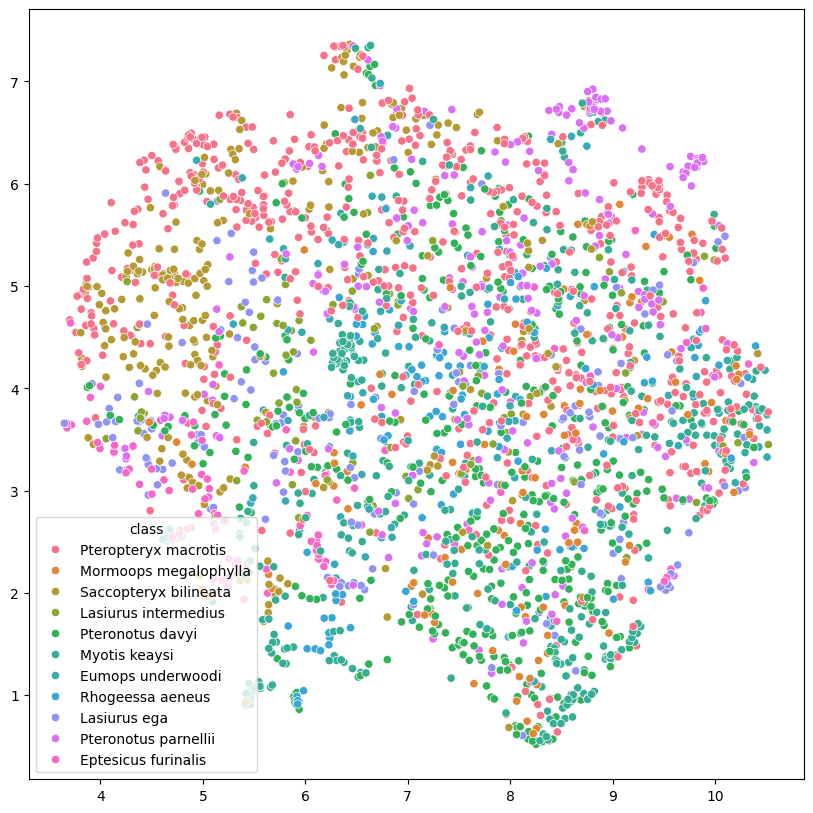

In [39]:
X, Y = umap_yamnet.T
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X, y=Y, hue=audio_clips["class"])

It seems difficult to disentangle bat species based on the feature sets and this UMAP plot. Well,
let us nonetheless try and use those features as input for a classifier to really see how well it
will work.

### 4.4 Exercise 🐝

Here you will build a Random Forest classifier using the features extracted by YamNet.

🖌️ Split the data into train and test. You can copy the code from the previous exercise.

In [40]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train_yamnet, X_test_yamnet, y_train_yamnet, y_test_yamnet = train_test_split(
    yamnet_features,
    audio_clips["class"],
    test_size=0.3,
    stratify=audio_clips["class"]       # notice we are using the stratified argument
)

🖌️ Train a random forest classifier using the training data.

In [41]:
# build a random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

# fit to training data
rf.fit(X_train_yamnet, y_train_yamnet)

RandomForestClassifier()

This time, we will use cross-validation instead of a dedicated validation set. Scikit-learn has a
handy function
[cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
available for us.

🖌️ Implement crossvalidation by completing the code cell below. Then, tweak the Random Forest's
hyperparameters based on this result until you are happy to move on to the test set.

In [42]:
from sklearn.model_selection import cross_val_score

# create new Random Forest object
rf = RandomForestClassifier(n_estimators=500)

# calculate crossvalidation (CV) performance scores
scores = cross_val_score(rf,
                         X_train_yamnet,
                         y_train_yamnet,
                         cv=5)

# report CV score statistics
print(f'CV score mean: {scores.mean():.2%}, std: {scores.std():.2%}.')

CV score mean: 53.35%, std: 2.00%.


🖌️ Once you are happy enough with the performance, evaluate the performance using the
classification_report function.

In [43]:
# we still need to fit the final model
rf.fit(X_train_yamnet, y_train_yamnet)

# predict on the test set
y_pred_yamnet = rf.predict(X_test_yamnet)

# evaluate using the classification_report
print(classification_report(y_true=y_test_yamnet, y_pred=y_pred_yamnet))

                       precision    recall  f1-score   support

  Eptesicus furinalis       0.50      0.40      0.44        30
    Eumops underwoodi       0.50      0.07      0.12        30
         Lasiurus ega       0.50      0.27      0.35        52
 Lasiurus intermedius       0.80      0.15      0.26        26
Mormoops megalophylla       0.00      0.00      0.00        37
        Myotis keaysi       0.69      0.71      0.70       118
     Pteronotus davyi       0.51      0.64      0.57       135
 Pteronotus parnellii       0.67      0.41      0.51        76
 Pteropteryx macrotis       0.49      0.81      0.61       199
     Rhogeessa aeneus       0.92      0.28      0.42        40
Saccopteryx bilineata       0.61      0.65      0.63        83

             accuracy                           0.56       826
            macro avg       0.56      0.40      0.42       826
         weighted avg       0.56      0.56      0.52       826



🖌️ Plot the confusion matrix. Tip: check the [scikit-learn
documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

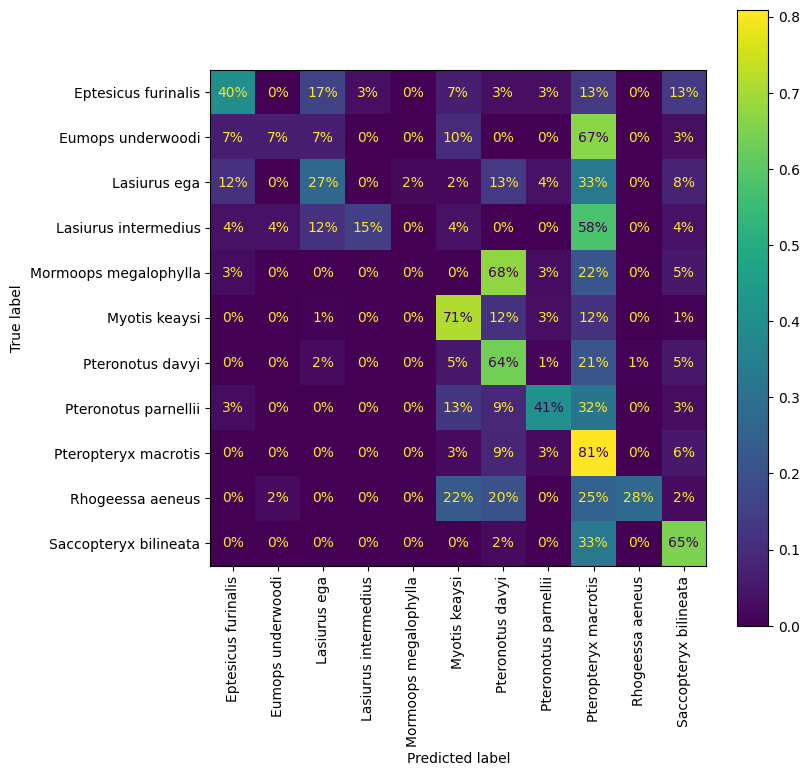

In [44]:
# compute the confusion matrix and normalise each row to get percentages
cm = confusion_matrix(y_true=y_test_yamnet, y_pred=y_pred_yamnet, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))

# plot the confusion matrix using the ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(
    xticks_rotation="vertical",
    values_format=".0%",
    ax=ax
)

🖌️ Which are the worst performing species? Can you see why? You might need to go back and see some
more examples of bat calls.

_Solution:_

💡 **Caveat**: Answers are likely to be different each run, as dataset splits and random forest
training are random.

*Mormoops megalophylla* and *Eumops underwoodi* were the worst-performing species.

This could be explained by:
* Low number of examples (see "support" in accuracy report table). Note that this is especially
  problematic given YamNet produces a 1024-dimensional feature vector. With insufficient numbers of
  examples we run into the **curse of dimensionality** issue (see Session 2).
* Related to this is class imbalance, respectively long-tailed class distribution in general.
  Although this affects Random Forests less than _e.g._ deep learning models, it can still cause
  mayhem.
* Little clustering and insufficient separation of YamNet features (see UMAP scatter plot).
* Difficult call signature overall (see visualisations of spectrogram).


From an ecological perspective:
* The training examples might not cover the whole range of call variation. Test calls could contain
  call types not seen during training. This could be fixed by collecting more data, or generating
  synthetic data.
* There also seems to be substantial overlap between echolocation calls of different species. This
  could be due to errors in labelling. Errors in the annotation process are common and should be
  expected. This could be fixed by conducting a review process in which suspicious annotations are
  verified or corrected. An annotation can be flagged as suspicious if its features lie far from the
  usual distribution (outlier detection), or if the model is confidently wrong about its class (hard
  example mining).
* Bat echolocation calls are are used to navigate and detect pray. If habitual flying space and/or
  prey are similar for two species they will tend to echolocate in a similar fashion. When this is
  the case using a different classification scheme for bats, such as one based on ecological traits,
  might be better suited for the task of acoustic identification.
* Sound production is also constrained by morphology. Closely related species will tend to have
  similar sound production capabilities and thus similar echolocation calls. However, this is not
  always the case as echolocation call is heavily constrained by ecology (as mentioned in the
  previous point). A potential workaround is to classify to a higher taxonomic level such as genus
  or family.
* Selected call features cannot discern between species. It could be the case that there are subtle
  cues in the audio that aid identification but haven't been measured. In this case either more
  features should be designed and measured, or adopting an approach of automated feature extraction
  (such as deep learning approaches) could help find a better feature set for acoustic
  identification.

### 4.5 Bonus: Specialised Features with Perch

The above solution did not really work that well. As you have seen in the UMAP plot, the YamNet
features do not sufficiently capture the patterns in the data to be able to separate calls by bat
species.

However, above we also talked about another model that has been trained more for acoustic data:
[Perch](https://github.com/google-research/perch/tree/main). What if we could use its features
instead of YamNet? Let us try that here!

First, let's calculate those. Perch is also
[available](https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8)
in TensorFlow Hub, which is great:

In [45]:
# load model
model_perch = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

Perch however does differ from Yamnet in how it outputs features (and predictions).

We thus have to re-implement feature extraction for it:

In [57]:
perch_features = []
for _, row in audio_clips.iterrows():
    # load audio data into memory
    wav = load_bat_call_audio_data(
        os.path.join(YUCATAN_AUDIO_DIR, str(row.recording_id)),
        row.start_time,
        row.end_time
    )

    # perch expects five second clips (and 32 kHz sampling rate); if an audio snippet is too short, we will pad it with zeros
    wav = np.pad(wav, [[0, 5*32_000 - len(wav)]])

    # predict using Perch
    model_outputs = model_perch.infer_tf(wav[np.newaxis,:]) # newaxis: Perch expects array of num channels x num samples

    # extract and append features (also known as "embeddings")
    perch_features.append(model_outputs['embedding'])

# combine features into single NumPy array
perch_features = np.array(perch_features).squeeze()         # squeeze(): remove channel dimension again (we want monaural features only)

Let's print the shape of the Perch features:

In [58]:
print(perch_features.shape)

(2751, 1280)


Slightly larger than YamNet (1280 _vs._ 1024), but are they any better? Let's find out!

🖌️ Redo the above steps including calculation of UMAP plot and training and evaluation using Random
Forest. Watch what happens.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


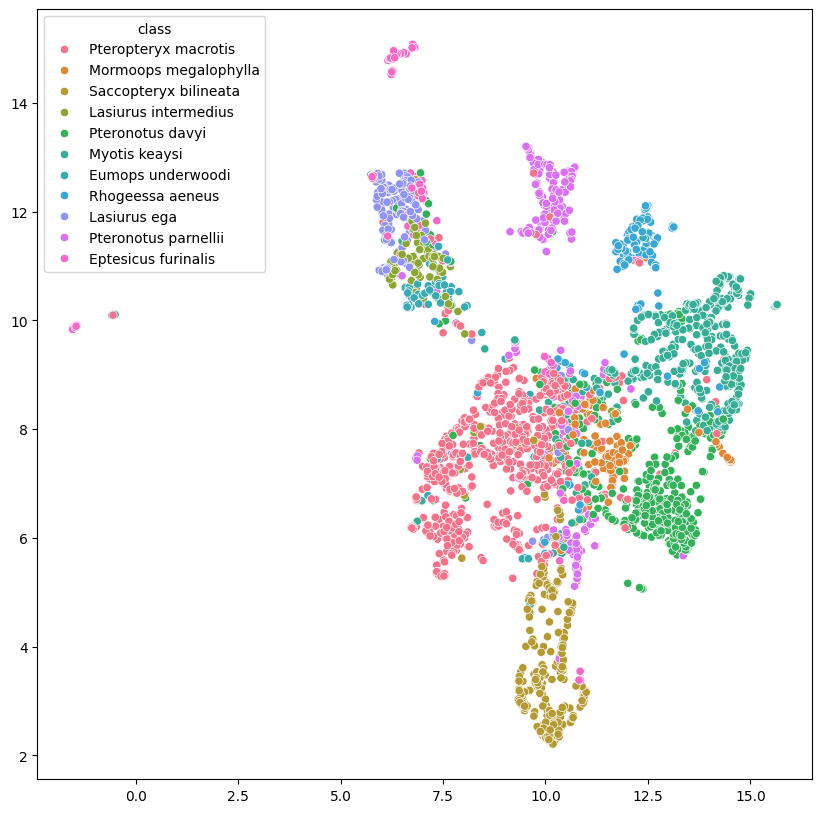

In [59]:
# create UMAP plot
umap_perch = UMAP().fit_transform(StandardScaler().fit_transform(perch_features))
X, Y = umap_perch.T
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X, y=Y, hue=audio_clips["class"])

CV score mean: 85.30%, std: 0.97%.
                       precision    recall  f1-score   support

  Eptesicus furinalis       1.00      0.70      0.82        30
    Eumops underwoodi       0.88      0.73      0.80        30
         Lasiurus ega       0.78      0.90      0.84        52
 Lasiurus intermedius       0.70      0.54      0.61        26
Mormoops megalophylla       1.00      0.49      0.65        37
        Myotis keaysi       0.90      0.95      0.92       118
     Pteronotus davyi       0.84      0.87      0.85       135
 Pteronotus parnellii       0.96      0.89      0.93        76
 Pteropteryx macrotis       0.80      0.93      0.86       199
     Rhogeessa aeneus       0.94      0.85      0.89        40
Saccopteryx bilineata       0.99      0.93      0.96        83

             accuracy                           0.87       826
            macro avg       0.89      0.80      0.83       826
         weighted avg       0.88      0.87      0.86       826



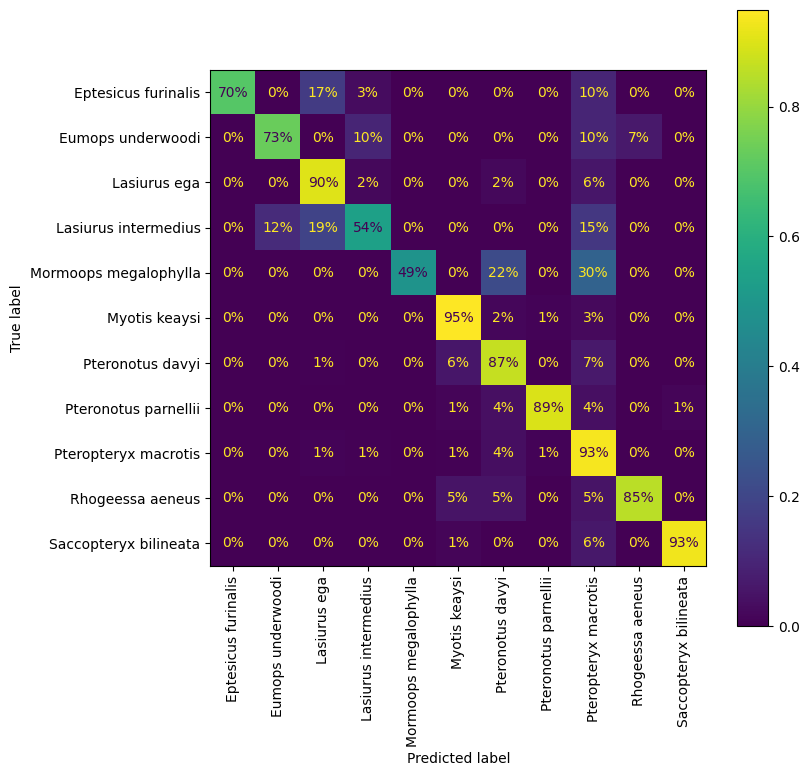

In [60]:
# split into train/test sets
X_train_perch, X_test_perch, y_train_perch, y_test_perch = train_test_split(
    perch_features,
    audio_clips["class"],
    test_size=0.3,
    stratify=audio_clips["class"]       # notice we are using the stratified argument
)


# create new Random Forest object
rf = RandomForestClassifier(n_estimators=500)

# calculate crossvalidation (CV) performance scores
scores = cross_val_score(rf,
                         X_train_perch,
                         y_train_perch,
                         cv=5)

# report CV score statistics
print(f'CV score mean: {scores.mean():.2%}, std: {scores.std():.2%}.')

# train final model
rf.fit(X_train_perch, y_train_perch)

# predict on the test set
y_pred_perch = rf.predict(X_test_perch)

# evaluate using the classification_report
print(classification_report(y_true=y_test_perch, y_pred=y_pred_perch))

# compute the confusion matrix and normalise each row to get percentages
cm = confusion_matrix(y_true=y_test_perch, y_pred=y_pred_perch, normalize="true")

_, ax = plt.subplots(figsize=(8, 8))

# plot the confusion matrix using the ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(
    xticks_rotation="vertical",
    values_format=".0%",
    ax=ax
)

---

## 5. Conclusion and Outlook

We saw some quite interesting phenomena today:
* It is totally possible to _detect_ bat calls with a general-purpose bat detector, at least to some
  degree.
* However, _classifying_ bat species was much harder.

We also explored different types of bat calls a bit – some of them are really hard to identify and
occur relatively rarely (a bat may use more echolocation than _e.g._ social calls), which adds to
the challenge.

Apart from collecting an enormous amount of labelled data and training a huge model, what else could
we do to improve performance in such a case?

Well, we have to go back as to why our Random Forest struggled a bit: one major reason is that
YamNet simply "had no idea" about bat calls. Those are unlikely to be present in YouTube audio
(training data). There is a mismatch between training and test data, or else, between the
pre-training task (for YamNet) and the target task (Yucatán bat call classification). In machine
learning terminology, this mismatch is known as **domain shift**, and it describes a gap (shift)
between _source_ and _target_ datasets. Real-world problems can have many domain shifts. We have
seen one here, but there can be others, such as:
* Acquiring data in different regions,
* different seasons,
* different years,
* with different sensors (_e.g._, microphones with different sensitivities, cameras with varying
  focal lengths, drones with different flying heights, _etc._),
* and so on.

All of this means that the model won't really know what to do under different domains unless it is
trained on the target data.

As it turns out, we have quite a number of approaches available to close this gap/shift between
source and target data, many of which are unsupervised (_i.e._, require no labels from the target
dataset). If you are interested in those, please let us know and we can talk about them in the
course.